# ABC calibration of $I_\text{CaL}$ in Nygren model to original dataset.

In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

INFO:myokit:Loading Myokit version 1.29.1


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for original dataset calibration:
 - Steady-state activation [Mewes1994]
 - Steady-state inactivation [Li1997]
 - Inactivation time constant (fast+slow) [Li1997]
 - Recovery time constant (fast+slow) [Li1997]

In [4]:
from experiments.ical_mewes import mewes_act
from experiments.ical_li import (li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)

Load the myokit modelfile for this channel.

In [5]:
modelfile = 'models/nygren_ical.mmt'

## Plot steady-state and time constant functions of original model

In [6]:
from ionchannelABC.visualization import plot_variables

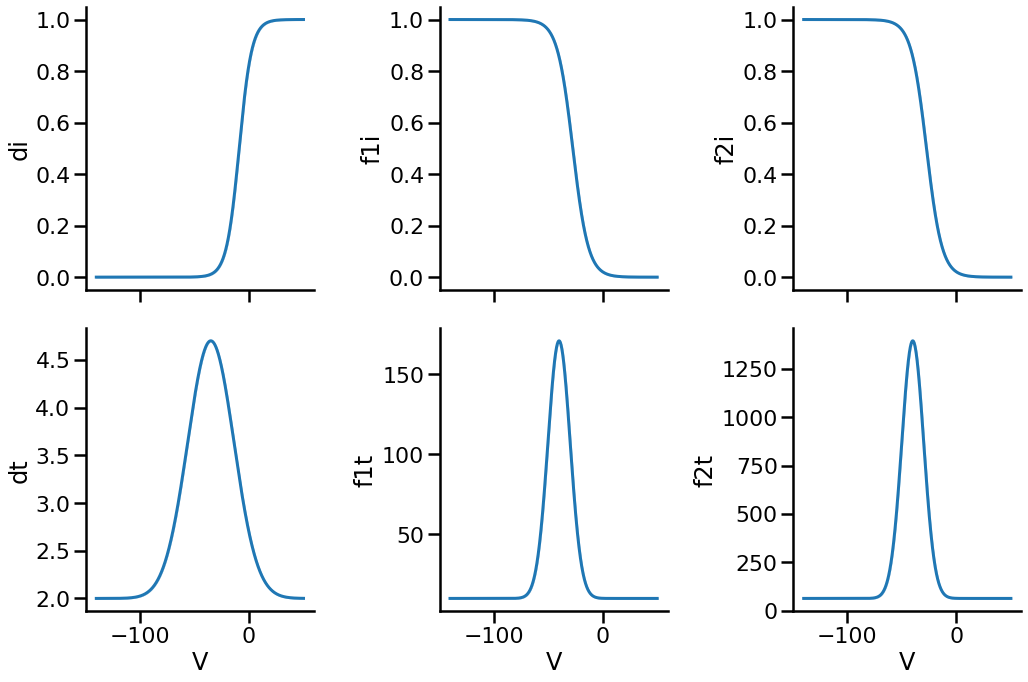

In [7]:
sns.set_context('poster')

V = np.arange(-140, 50, 0.01)

nyg_par_map = {'di': 'ical.d_inf',
            'f1i': 'ical.f_inf',
            'f2i': 'ical.f_inf',
            'dt': 'ical.tau_d',
            'f1t': 'ical.tau_f_1',
            'f2t': 'ical.tau_f_2'}

f, ax = plot_variables(V, nyg_par_map, 'models/nygren_ical.mmt', figshape=(3,2))

# Activation gate ($d$) calibration

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                mewes_act)
assert len(observations)==len(summary_statistics(model({})))

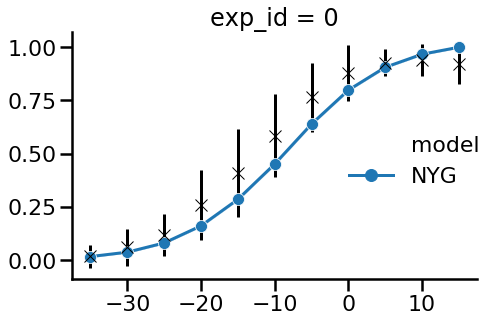

In [9]:
g = plot_sim_results(modelfile,
                     mewes_act)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [10]:
limits = {'ical.p1': (-50, 50),
          'ical.p2': (0, 20),
          'log_ical.p3': (-7, 3),
          'ical.p4': (-50, 50),
          'ical.p5': (0, 20),
          'log_ical.p6': (-7, 3)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [11]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "nygren_ical_dgate_original.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

Test theoretical number of particles for approximately 2 particles per dimension in the initial sampling of the parameter hyperspace.

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


Initialise ABCSMC (see pyABC documentation for further details).

IonChannelDistance calculates the weighting applied to each datapoint based on the experimental variance.

In [16]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(500),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),#initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.8620971283223635, '1': 1.1636171131795543, '2': 1.0342944621090917, '3': 0.6205155126018103, '4': 0.48986542101291475, '5': 0.5170198235080876, '6': 0.6205155126018118, '7': 0.7756730599221309, '8': 1.5522067038604508, '9': 1.3299008007726998, '10': 1.0342944621090833}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=from_sample, quantile_multiplier=1


In [17]:
# Convert observations to dictionary format for calibration
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [18]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=4, start_time=2020-01-27 16:53:37.402405, end_time=None)>


Run calibration with stopping criterion of particle 1\% acceptance rate.

In [19]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 1.411290730406114
INFO:ABC:t: 0, eps: 1.411290730406114.
DEBUG:ABC:Now submitting population 0.
DEBUG:ABC:Population 0 done.
DEBUG:ABC:Total samples up to t = 0: 1528.
INFO:ABC:Acceptance rate: 500 / 1028 = 4.8638e-01.
DEBUG:Epsilon:new eps, t=1, eps=0.7728394625029752
INFO:ABC:t: 1, eps: 0.7728394625029752.
DEBUG:ABC:Now submitting population 1.
DEBUG:ABC:Population 1 done.
DEBUG:ABC:Total samples up to t = 1: 2838.
INFO:ABC:Acceptance rate: 500 / 1310 = 3.8168e-01.
DEBUG:Epsilon:new eps, t=2, eps=0.5157906004027857
INFO:ABC:t: 2, eps: 0.5157906004027857.
DEBUG:ABC:Now submitting population 2.
DEBUG:ABC:Population 2 done.
DEBUG:ABC:Total samples up to t = 2: 4722.
INFO:ABC:Acceptance rate: 500 / 1884 = 2.6539e-01.
DEBUG:Epsilon:new eps, t=3, eps=0.40706979538278715
INFO:ABC:t: 3, eps: 0.40706979538278715.
DEBUG:ABC:Now submitting population 3.
DEBUG:ABC:Population 3 done.
DEBUG:ABC:Total samples up to t = 3: 7127.

DEBUG:ABC:Population 31 done.
DEBUG:ABC:Total samples up to t = 31: 145522.
INFO:ABC:Acceptance rate: 500 / 6153 = 8.1261e-02.
DEBUG:Epsilon:new eps, t=32, eps=0.08916866407968603
INFO:ABC:t: 32, eps: 0.08916866407968603.
DEBUG:ABC:Now submitting population 32.
DEBUG:ABC:Population 32 done.
DEBUG:ABC:Total samples up to t = 32: 153462.
INFO:ABC:Acceptance rate: 500 / 7940 = 6.2972e-02.
DEBUG:Epsilon:new eps, t=33, eps=0.08881476996135677
INFO:ABC:t: 33, eps: 0.08881476996135677.
DEBUG:ABC:Now submitting population 33.
DEBUG:ABC:Population 33 done.
DEBUG:ABC:Total samples up to t = 33: 161440.
INFO:ABC:Acceptance rate: 500 / 7978 = 6.2672e-02.
DEBUG:Epsilon:new eps, t=34, eps=0.08732639535133546
INFO:ABC:t: 34, eps: 0.08732639535133546.
DEBUG:ABC:Now submitting population 34.
DEBUG:ABC:Population 34 done.
DEBUG:ABC:Total samples up to t = 34: 227643.
INFO:ABC:Acceptance rate: 500 / 66203 = 7.5525e-03.
DEBUG:Epsilon:new eps, t=35, eps=0.08712997913365059
INFO:History:Done <ABCSMC(id=4, s

## Analysis of results

In [17]:
history = History(db_path)

In [11]:
history.all_runs()

[]

In [8]:
df, w = history.get_distribution()

In [9]:
df.describe()

name,ical.p1,ical.p2,ical.p4,ical.p5,log_ical.p3,log_ical.p6
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2.660959,5.051521,-11.522957,18.561873,-0.979001,-1.997502
std,0.106361,0.015746,0.066002,0.131535,0.006481,0.017004
min,2.379048,5.004041,-11.700679,18.179155,-1.020526,-2.056282
25%,2.563624,5.041556,-11.581179,18.459250,-0.980587,-2.009898
50%,2.650883,5.053798,-11.528060,18.540711,-0.978655,-1.998095
75%,2.726056,5.063433,-11.477077,18.643031,-0.975676,-1.982758
max,3.010518,5.092141,-11.305433,19.007142,-0.968020,-1.938702


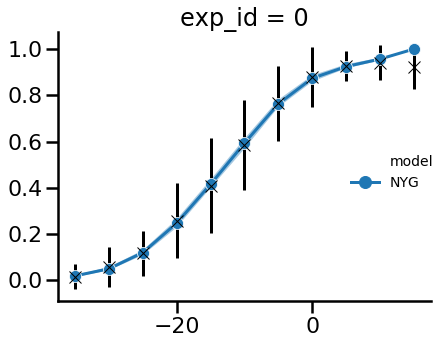

In [23]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     mewes_act,
                     df=df, w=w)

plt.tight_layout()

In [24]:
import pandas as pd
N = 100

nyg_par_samples = df.sample(n=N, weights=w, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

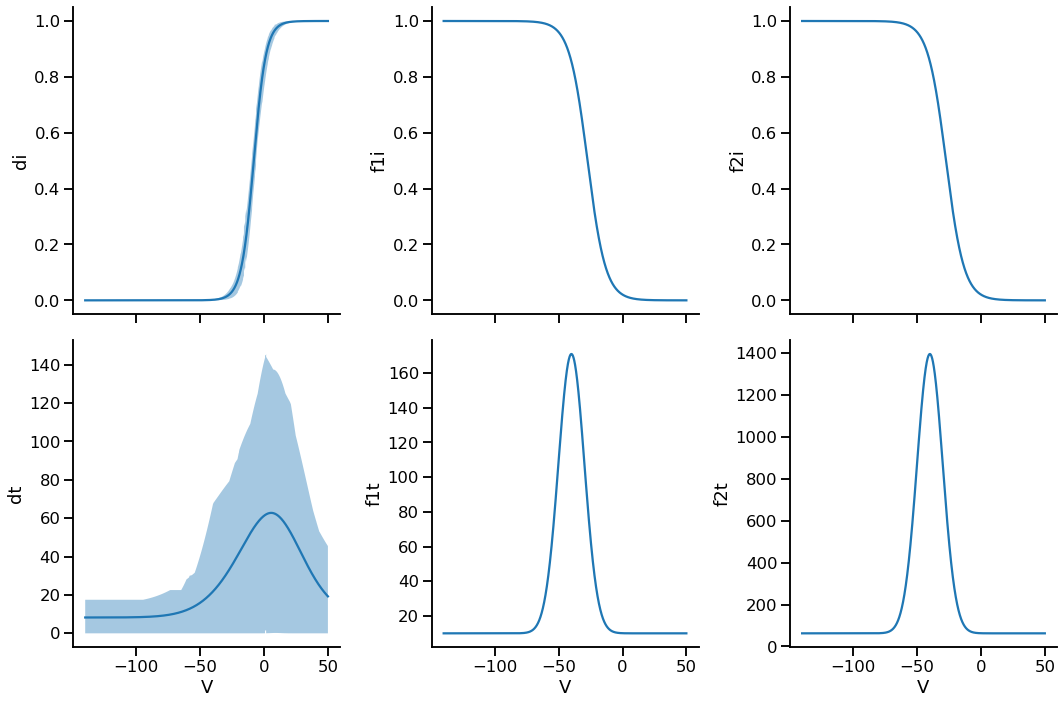

In [25]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_par_map, 
                       'models/nygren_ical.mmt', 
                       [nyg_par_samples],
                       figshape=(3,2))

In [26]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [27]:
m,_,_ = myokit.load(modelfile)

In [28]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

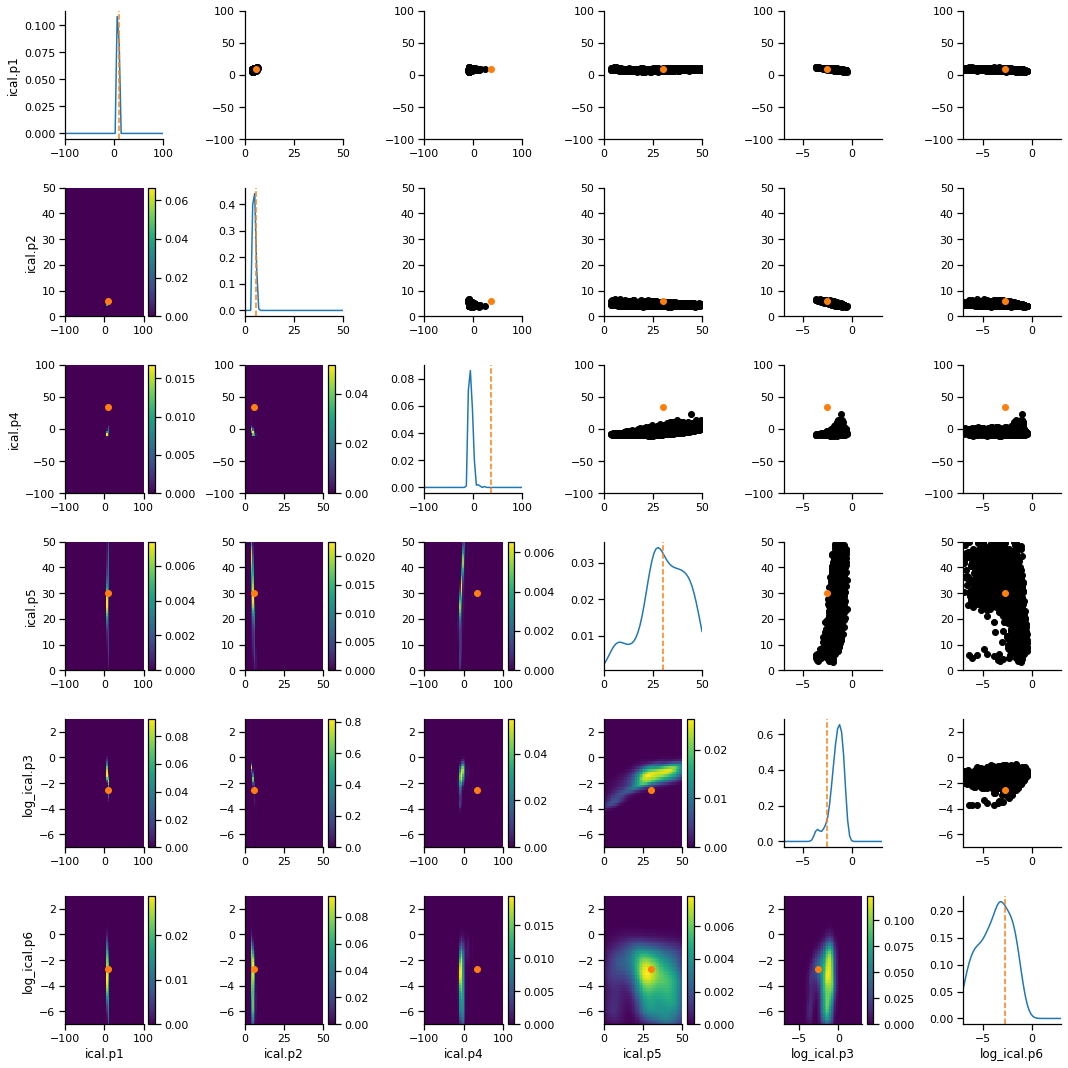

In [29]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

# Voltage-dependent inactivation gate ($f$) calibration

In [19]:
observations, model, summary_statistics = setup(modelfile,
                                                li_inact_1000,
                                                li_inact_kin_80,
                                                li_recov)

In [20]:
assert len(observations)==len(summary_statistics(model({})))

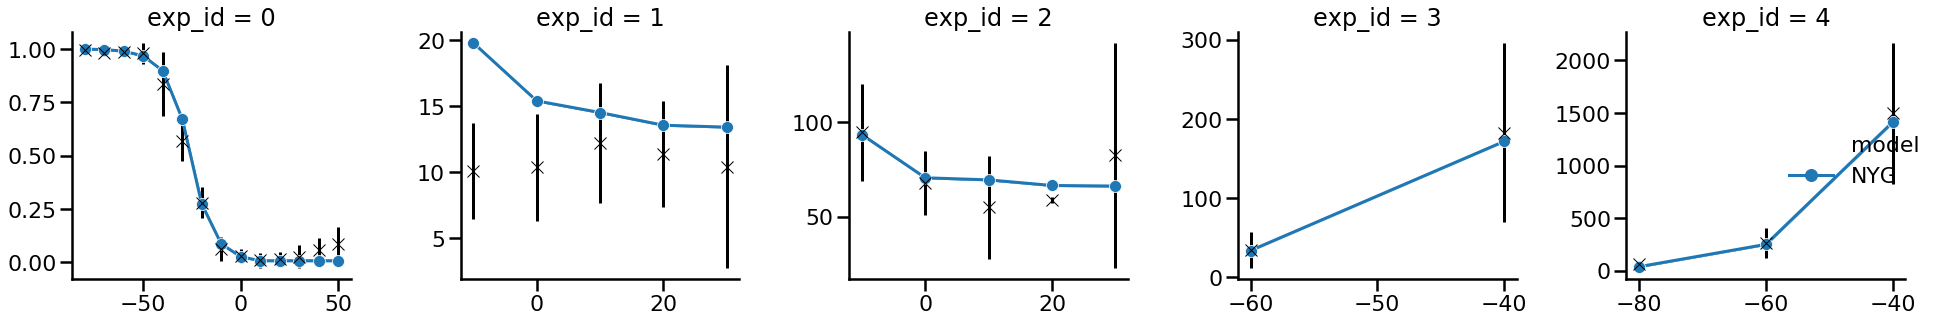

In [21]:
g = plot_sim_results(modelfile,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov)

In [22]:
limits = {'ical.q1': (0, 100),
          'ical.q2': (0, 50),
          'log_ical.q3': (-7, 3),
          'ical.q4': (0, 100),
          'ical.q5': (0, 50),
          'log_ical.q6': (-7, 3),
          'log_ical.r1': (-7, 3),
          'ical.r2': (0, 100),
          'ical.r3': (0, 100),
          'log_ical.r4': (-7, 3)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [23]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [24]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "nygren_ical_fgates_original.db"))

In [36]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [37]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [38]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9837148289810969, '1': 0.9837148289810969, '2': 0.9837148289810969, '3': 0.9837148289810969, '4': 0.32559180605160337, '5': 0.5055241199222263, '6': 0.6753486289586008, '7': 0.8392681990941823, '8': 0.9837148289810969, '9': 0.9837148289810969, '10': 0.9837148289810969, '11': 0.9196236649649017, '12': 0.8392681990941823, '13': 0.630982660632852, '14': 0.4608478344438249, '15': 0.41845619672000584, '16': 0.3688677609080382, '17': 0.4191992497796025, '18': 0.21952975590454926, '19': 0.5102122707484876, '20': 0.7659862673065291, '21': 0.4791367008919786, '22': 2.7544015211470714, '23': 0.21885528270246787, '24': 2.7490646934055025, '25': 0.5560031468540616, '26': 4.590669201911785, '27': 2.354305935366495, '28': 0.5128531003233775}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [39]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [40]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-12-17 18:11:15.560975, end_time=None)>


In [41]:
history = abc.run(minimum_epsilon=0., max_nr_populations=10, min_acceptance_rate=0.01)

INFO:ABC:t: 0, eps: 100.
DEBUG:ABC:Now submitting population 0.
DEBUG:ABC:Population 0 done.
DEBUG:ABC:Total samples up to t = 0: 17682.
INFO:ABC:Acceptance rate: 2000 / 17682 = 1.1311e-01.
DEBUG:Epsilon:new eps, t=1, eps=20.218880525807926
INFO:ABC:t: 1, eps: 20.218880525807926.
DEBUG:ABC:Now submitting population 1.
DEBUG:ABC:Population 1 done.
DEBUG:ABC:Total samples up to t = 1: 27035.
INFO:ABC:Acceptance rate: 2000 / 9353 = 2.1384e-01.
DEBUG:Epsilon:new eps, t=2, eps=9.05238539533155
INFO:ABC:t: 2, eps: 9.05238539533155.
DEBUG:ABC:Now submitting population 2.
DEBUG:ABC:Population 2 done.
DEBUG:ABC:Total samples up to t = 2: 37902.
INFO:ABC:Acceptance rate: 2000 / 10867 = 1.8404e-01.
DEBUG:Epsilon:new eps, t=3, eps=3.2145686554261843
INFO:ABC:t: 3, eps: 3.2145686554261843.
DEBUG:ABC:Now submitting population 3.
DEBUG:ABC:Population 3 done.
DEBUG:ABC:Total samples up to t = 3: 50055.
INFO:ABC:Acceptance rate: 2000 / 12153 = 1.6457e-01.
DEBUG:Epsilon:new eps, t=4, eps=1.9753436253693

In [42]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 10, eps: 1.0578826712902287.
DEBUG:ABC:Now submitting population 10.
DEBUG:ABC:Population 10 done.
DEBUG:ABC:Total samples up to t = 10: 588723.
INFO:ABC:Acceptance rate: 2000 / 149469 = 1.3381e-02.
DEBUG:Epsilon:new eps, t=11, eps=1.0112463761417099
INFO:ABC:t: 11, eps: 1.0112463761417099.
DEBUG:ABC:Now submitting population 11.
DEBUG:ABC:Population 11 done.
DEBUG:ABC:Total samples up to t = 11: 700015.
INFO:ABC:Acceptance rate: 2000 / 111292 = 1.7971e-02.
DEBUG:Epsilon:new eps, t=12, eps=0.978278613072101
INFO:ABC:t: 12, eps: 0.978278613072101.
DEBUG:ABC:Now submitting population 12.
DEBUG:ABC:Population 12 done.
DEBUG:ABC:Total samples up to t = 12: 863210.
INFO:ABC:Acceptance rate: 2000 / 163195 = 1.2255e-02.
DEBUG:Epsilon:new eps, t=13, eps=0.9536787695189626
INFO:ABC:t: 13, eps: 0.9536787695189626.
DEBUG:ABC:Now submitting population 13.
DEBUG:ABC:Population 13 done.
DEBUG:ABC:Total samples up to t = 13: 1073401.
INFO:ABC:Acceptance rate: 2000 / 210191 = 9.5152e-03.
D

### Database results analysis

In [25]:
history = History(db_path)

In [26]:
df, w = history.get_distribution(m=0)

In [27]:
df.describe()

name,ical.q1,ical.q2,ical.q4,ical.q5,ical.r2,ical.r3,log_ical.q3,log_ical.q6,log_ical.r1,log_ical.r4
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,30.321888,7.086246,56.398784,23.881013,53.796645,53.828049,-2.243882,-1.886848,-2.271101,-2.269780
std,6.188146,3.844569,22.818212,13.046897,25.474760,27.484299,1.913473,0.466871,1.772640,1.295454
min,11.705284,0.005643,0.398389,0.008983,0.050621,0.178847,-6.970469,-2.731065,-6.980133,-6.992341
25%,25.839533,4.209786,40.016499,13.063986,35.243108,29.935015,-3.478830,-2.238161,-3.241617,-2.456751
50%,29.748317,6.655406,56.581341,23.229325,55.078437,56.257167,-1.690625,-2.098706,-1.591136,-2.069147
75%,34.335679,9.406662,74.259265,34.642467,74.310714,77.659496,-0.884309,-1.280987,-0.997886,-1.289475
max,61.052846,23.041122,99.829090,49.953508,99.850154,99.988806,2.301194,-1.127171,2.024928,-1.128604


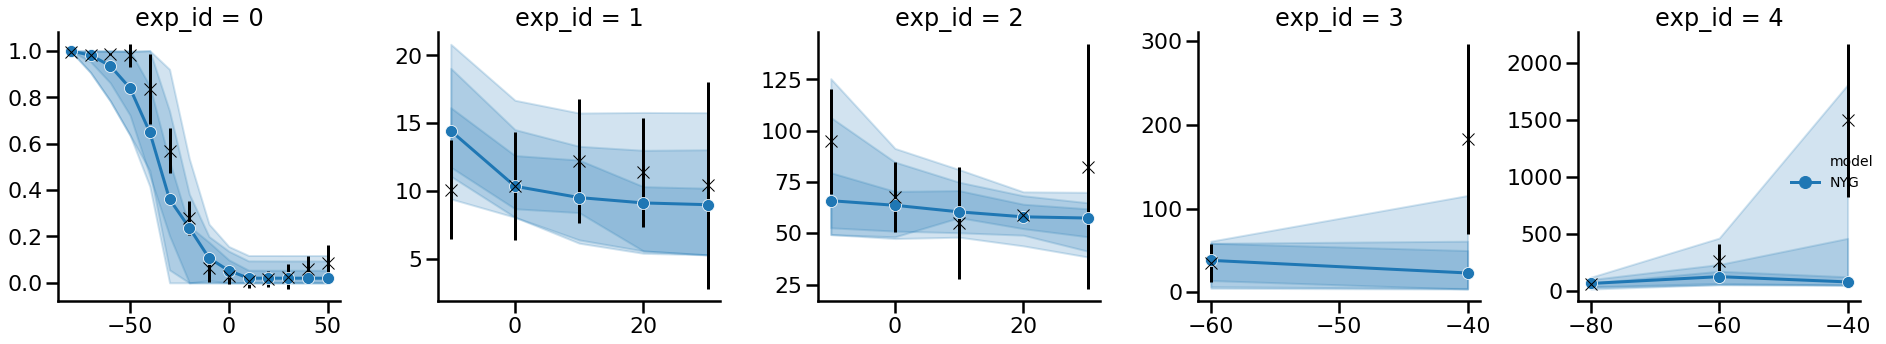

In [28]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov,
                     df=df, w=w)

plt.tight_layout()

In [47]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [48]:
m,_,_ = myokit.load(modelfile)

In [49]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

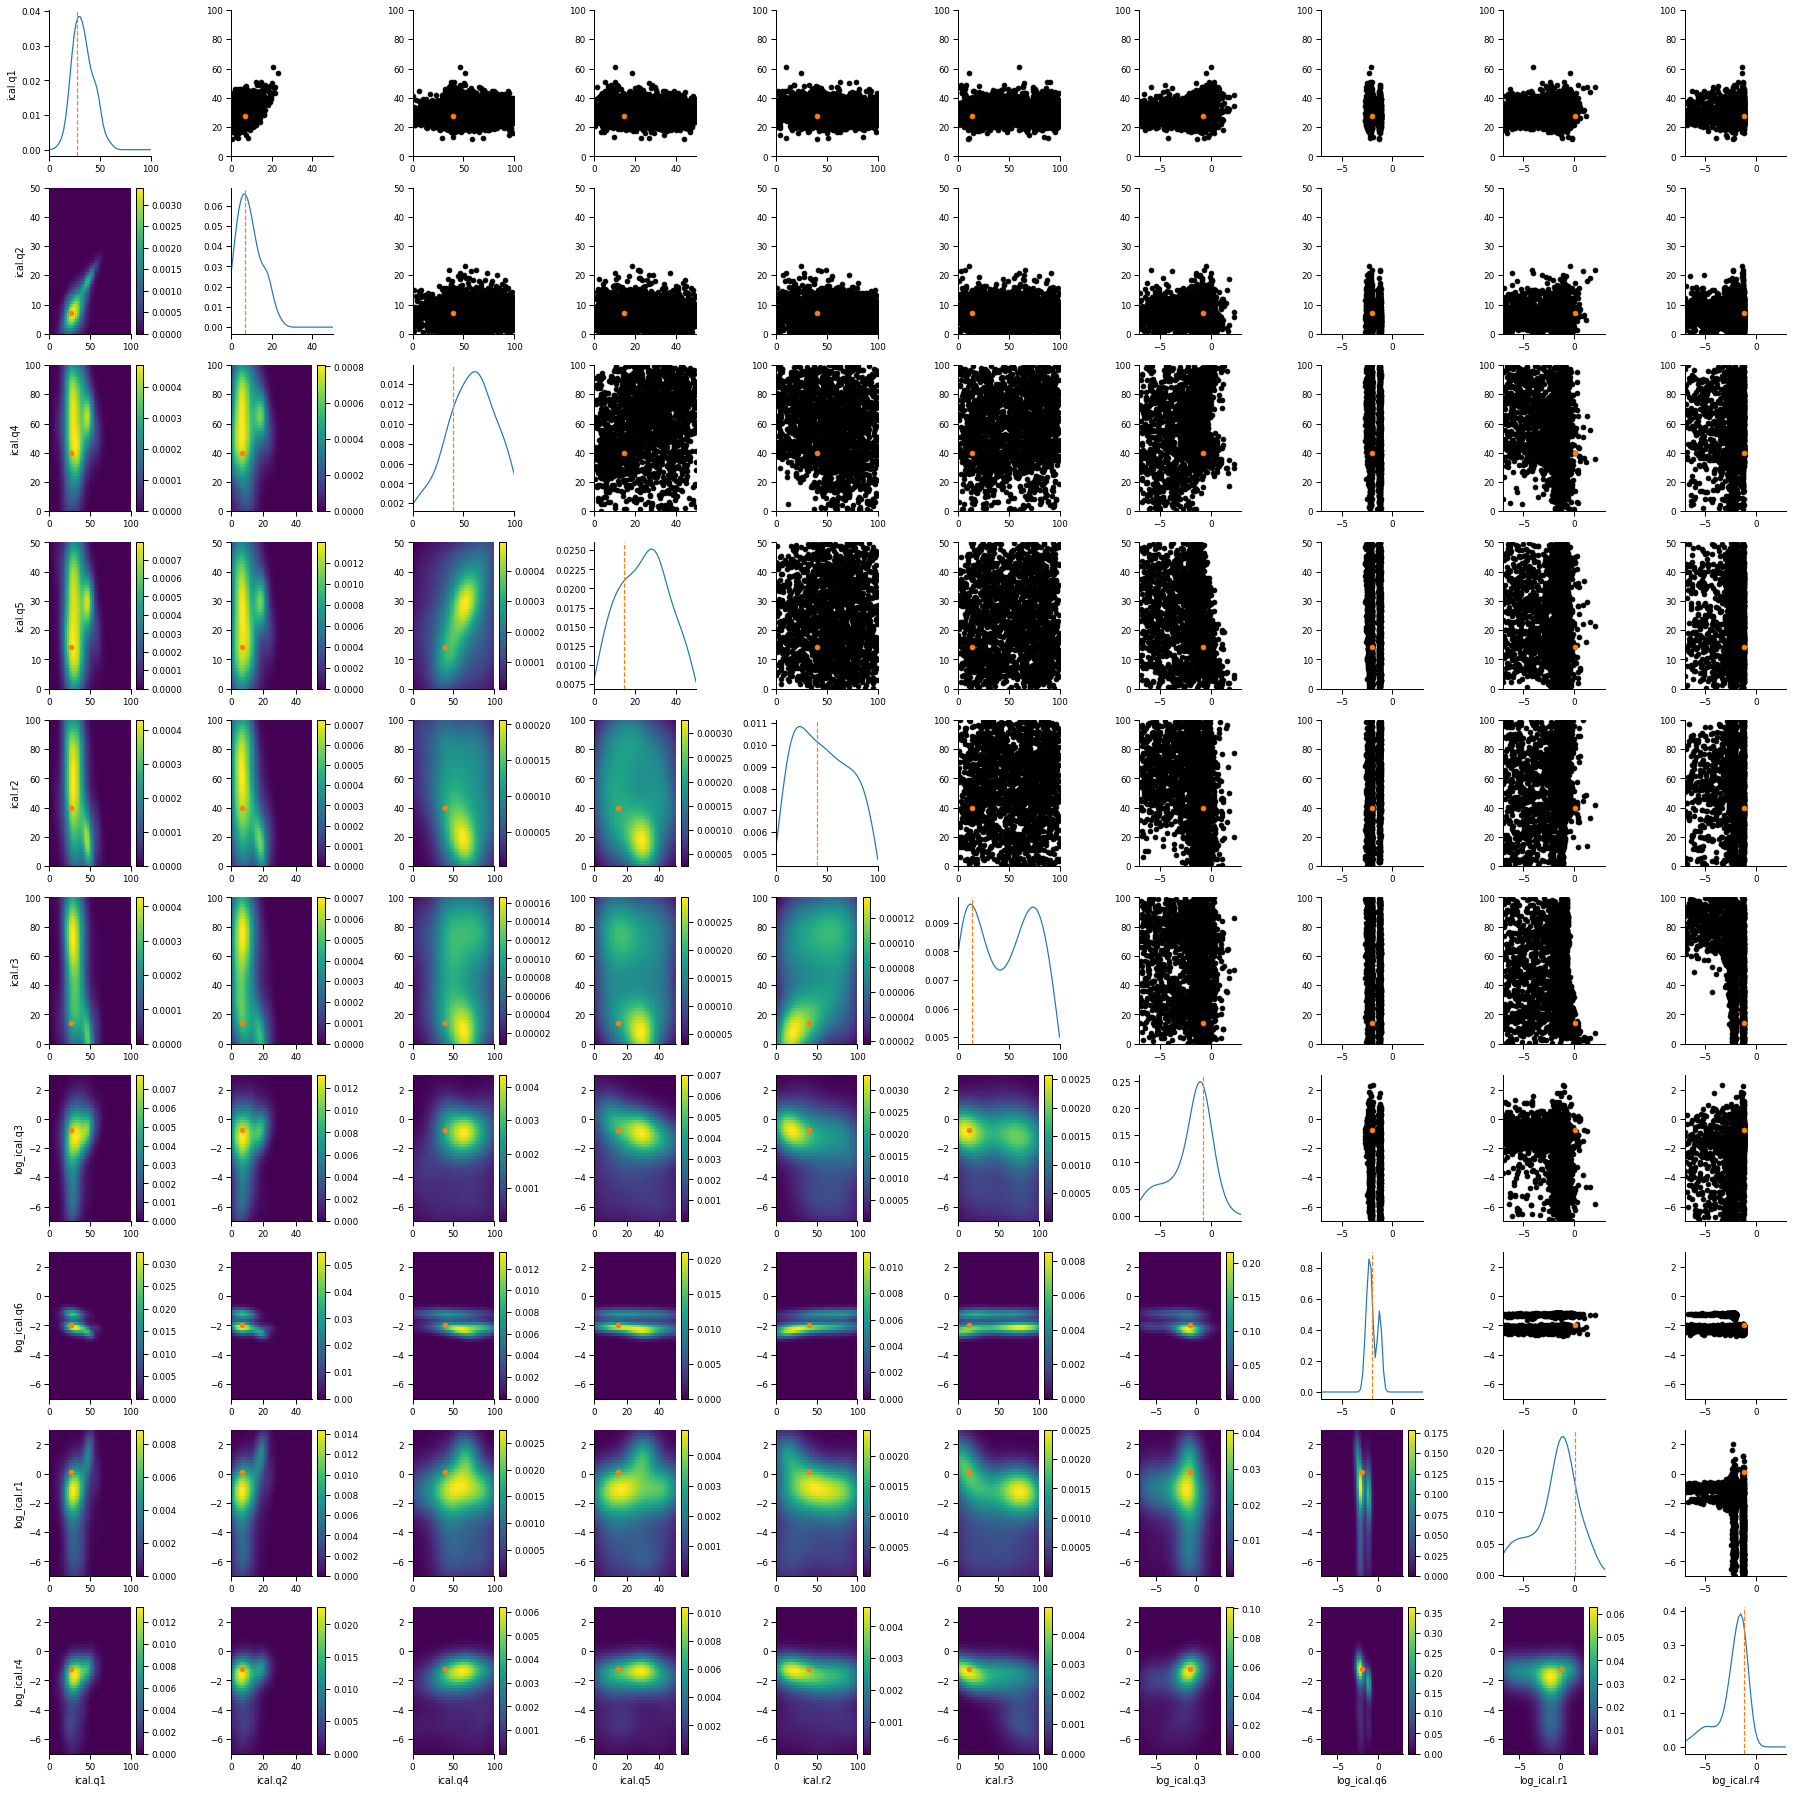

In [50]:
sns.set_context('paper')

g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

plt.tight_layout()

In [31]:
import pandas as pd
N = 100
nyg_par_samples = df.sample(n=N, weights=w, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

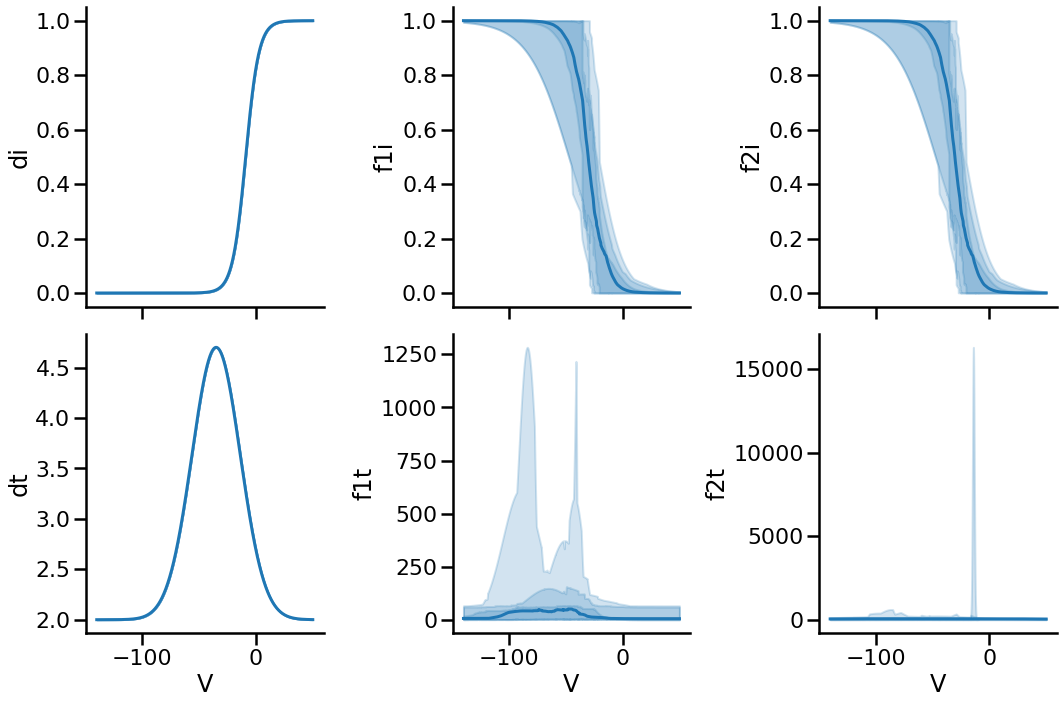

In [32]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_par_map, 
                       'models/nygren_ical.mmt', 
                       [nyg_par_samples],
                       figshape=(3,2))

plt.tight_layout()